# NFL Big Data Bowl

### 1. Description


American football is a complex sport. There are 22 players on the field throughout the game. Fundamentally, the goal of football is for the offense to run (rush) or throw (pass) the ball to gain yards, moving towards, then across, the opposing team’s side of the field in order to score,called a touchdown. And the goal of the defense is to prevent the offensive team from scoring.The offense has 4 tries called Downs to gain a minimum of 10 yards or else they lose possession of the ball.

In the National Football League (NFL), roughly a third of teams’ offensive yardage comes from run(rush) plays. Ball carriers are generally assigned the most credit for these plays, but their teammates (by way of blocking), coach (by way of play call), and the opposing defense also play a critical role. The NFL aims to provide better context into what contributes to a successful run play.

We are tasked to find the amount of Yards gained based on the data collected at the moment of Handoff. We are only predicting for Rushing Plays.

[Source: NFL Big Data Bowl Kaggle](https://www.kaggle.com/c/nfl-big-data-bowl-2020/data)
***

### 1.2 Problem Statement


For each Play, we must predict a cumulative probability distribution for the yardage gained or
lost.<br> Each prediction indicates the probability that the team gains <= that many yards on the play.<br>
Because this was a time-series code competition that
was evaluated on real future data,<br> we have to run the entire code on Kaggle to get it evaluated,
even the training portions, the test data provided is encrypted.

If predictions are fast enough it could be used for graphics on Live Tv as the play happens.
Modelling process could show insights into what attributes contribute most among the features provided.

### 1.3 Data Overview

Each row in the file corresponds to a single player's involvement in a single play. <br>
The following features are included in the dataset:
-    GameId - a unique game identifier
-    PlayId - a unique play identifier
-    Team - home or away
-    X - player position along the long axis of the field. 
-    Y - player position along the short axis of the field.
-    S - speed in yards/second
-    A - acceleration in yards/second^2
-    Dis - distance traveled from prior time point, in yards
-    Orientation - orientation of player (deg)
-    Dir - angle of player motion (deg)
-    NflId - a unique identifier of the player
-    DisplayName - player's name
-    JerseyNumber - jersey number
-    Season - year of the season
-    YardLine - the yard line of the line of scrimmage
-    Quarter - game quarter (1-5, 5 == overtime)
-   GameClock - time on the game clock
-    PossessionTeam - team with possession
-    Down - the down (1-4)
-    Distance - yards needed for a first down
-   FieldPosition - which side of the field the play is happening on
-   HomeScoreBeforePlay - home team score before play started
-   VisitorScoreBeforePlay - visitor team score before play started
-   NflIdRusher - the NflId of the rushing player
-   OffenseFormation - offense formation
-   OffensePersonnel - offensive team positional grouping
-   DefendersInTheBox - number of defenders lined up near the line of scrimmage, spanning the width of the offensive line
-   DefensePersonnel - defensive team positional grouping
-   PlayDirection - direction the play is headed
-   TimeHandoff - UTC time of the handoff
-   TimeSnap - UTC time of the snap
-   **Yards** - the yardage gained on the play (We are predicting this)
-   PlayerHeight - player height (ft-in)
-   PlayerWeight - player weight (lbs)
-   PlayerBirthDate - birth date (mm/dd/yyyy)
-   PlayerCollegeName - where the player attended college
-   Position - the player's position (the specific role on the field that they typically play)
-   HomeTeamAbbr - home team abbreviation
-   VisitorTeamAbbr - visitor team abbreviation
-   Week - week into the season
-   Stadium - stadium where the game is being played
-   Location - city where the game is being played
-   StadiumType - description of the stadium environment
-   Turf - description of the field surface
-   GameWeather - description of the game weather
-   Temperature - temperature (deg F)
-   Humidity - humidity
-   WindSpeed - wind speed in miles/hour
-   WindDirection - wind direction

### 1.4 Business objectives and constraints:  

- low-latency not required but could be useful.
- Probability of prediction is useful to measure impact of players, external factors in gaining yardage

### 1.5 Performance Metric

1) **Mean Absolute error** 


Continuous Values from -99 to 99
***

2) **Continuous Rank Probability Score**

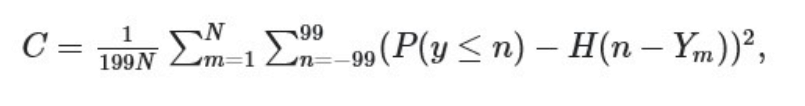

    Where,
    P is predicted Distribution,
    N is number of plays in the test set,
    Y is the number of actual Yards,
    H(x) the Heaviside step function
    H (x)=1 for x ≥0 and zero otherwise
    CRPS is the mean square error (MSE)of the predicted Cumulative density function (CDF) and
    the true Cumulative density function (CDF).
    The Continuous Ranked Probability Score (CRPS) generalizes the Mean Absolute Error(MAE)
    to the case of probabilistic forecasts. CPRS is used for accuracy metrics where probabilistic
    forecasts are involved.

Kaggle wants submission to be in this format

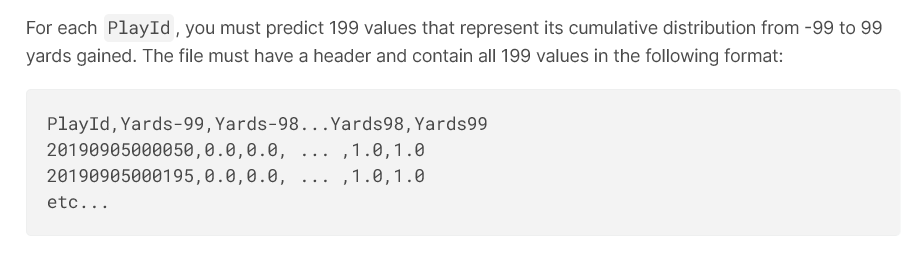

## 2. Reading Data and Preprocessing

### 2.1 Importing Libraries and Reading Files 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook as tqdm
import re
from string import punctuation
from prettytable import PrettyTable

pd.set_option("display.max_columns",None)

data=pd.read_csv('train.csv',low_memory=False)
np.random.seed(43)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682154 entries, 0 to 682153
Data columns (total 49 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   GameId                  682154 non-null  int64  
 1   PlayId                  682154 non-null  int64  
 2   Team                    682154 non-null  object 
 3   X                       682154 non-null  float64
 4   Y                       682154 non-null  float64
 5   S                       682154 non-null  float64
 6   A                       682154 non-null  float64
 7   Dis                     682154 non-null  float64
 8   Orientation             682131 non-null  float64
 9   Dir                     682126 non-null  float64
 10  NflId                   682154 non-null  int64  
 11  DisplayName             682154 non-null  object 
 12  JerseyNumber            682154 non-null  int64  
 13  Season                  682154 non-null  int64  
 14  YardLine            

### 2.1 Preprocessing and Missing Values

#### Columns with missing values in percentage


In [3]:
print("Missing values in percentage\n ",data.isnull().sum()[data.isnull().sum()>0]/len(data)*100)

Missing values in percentage
  Orientation           0.003372
Dir                   0.004105
FieldPosition         1.261006
OffenseFormation      0.012900
DefendersInTheBox     0.003225
StadiumType           6.111523
GameWeather           8.820589
Temperature           9.330151
Humidity              0.903022
WindSpeed            13.467927
WindDirection        15.344922
dtype: float64


#### Missing Values and Data Preprocessing
- **Orientation** and **Direction** of players filled with the mean of the orientation of all players based on their position like wingback, rusher etc.
- **Temperature** filled with the mean temperature based on the season (2017/18/19) and based on the week(1-11)
- Unknown **Field Positions** were given an 'unknown' value since it is a decent chunk of unknown values
- **Defenders in the box, OffenseFormation** and **Humidity** filled with  the median values
- **Stadium Type** was classed into open or closed only 
- **Game Weather** divided into four buckets, rainy, sunny, cold or overcast. Each bucket having it's own numerical value
- **Windspeed** filled with only numerical values extracted from the description
- **WindDirection** cleaned and assigned values in degrees instead of description, for example northeast given the value of 90 degrees.

In [4]:
def preprocess():
    
    '''Preprocess and clean some of the data, assigning  values to missing values based on the feature and updating Team Abbrevations to remain consistent 
       Returns the list of columns with empty features'''
    
    orient=data.groupby('Position',as_index=False)['Orientation'].mean()
    Dir=data.groupby('Position',as_index=False)['Dir'].mean()
    OrientDict={}
    DirDict={}
    for i,j in orient.iterrows():
        OrientDict[j['Position']]=j['Orientation']
        DirDict[j['Position']]=j['Orientation']

    data.Dir=data.Dir.fillna(data.Position.map(DirDict))
    data.Orientation=data.Orientation.fillna(data.Position.map(OrientDict))

    tempsperweek=data.groupby(['Season','Week'],as_index=False)['Temperature'].mean()
    temp2017={}
    temp2018={}
    temp2019={}
    for i,j in tempsperweek.iterrows():
        if j['Season']==2017:
            temp2017[j['Week']]=j['Temperature']
        if j['Season']==2018:
            temp2018[j['Week']]=j['Temperature']
        if j['Season']==2019:
            temp2019[j['Week']]=j['Temperature']

    data.loc[(data.Season==2017) & (data.Temperature.isna()),'Temperature']=data.Temperature.fillna(data.Week.map(temp2017))
    data.loc[(data.Season==2018) & (data.Temperature.isna()),'Temperature']=data.Temperature.fillna(data.Week.map(temp2018))
    data.loc[(data.Season==2019) & (data.Temperature.isna()),'Temperature']=data.Temperature.fillna(data.Week.map(temp2019))

    data.loc[data.FieldPosition.isna(),'FieldPosition']='UNKNOWN'
    data.loc[data.OffenseFormation.isna(),'OffenseFormation']=data.OffenseFormation.value_counts().idxmax()

    data.loc[data.DefendersInTheBox.isna(),'DefendersInTheBox']=data.DefendersInTheBox.median()
    data.loc[data.Humidity.isna(),'Humidity']=data.Humidity.median()


    #Code to clean StadiumType 
    #code inspired from https://www.kaggle.com/sanshengshi/lightgbm-clean-stadiumtype
    def StadiumType(txt):
        txt=str(txt)
        txt=txt.lower()
        txt=txt.strip()
        if 'indoor' in txt or 'closed' in txt:
            return 0
        else:
            return 1   #outdoor or open or unspecified is being treated an as open field 
    data["StadiumType"]=data["StadiumType"].apply(StadiumType)

    def Gameweather(txt):
        txt=str(txt)
        txt=txt.lower()
        txt=txt.strip()
        if 'clear' in txt or 'sun' in txt or 'controlled' in txt or 'indoor' in txt:
            return 0
        if 'rain' in txt:
            return 1
        if 'cloud' in txt or 'overcast' in txt:
            return 0.5 
        if 'snow' in txt or 'overcast' in txt:
            return -0.5
        return 0                                   # Values given to differentiate between clear and rainy 
    data["GameWeather"]=data["GameWeather"].apply(Gameweather)

    def Windspeed(txt):
        if pd.isna(txt):
            return 7.0                   # Median Value   
        if '-' in txt:
            a,b=txt.split('-')
            return (float(a)+float(b))/2
        elif txt.isalnum():
            if re.match('(\d+)',str(txt)):
                return float(re.match('(\d+)',str(txt))[0])
            else:
                return 7.0
        else:
            return 0
    data["WindSpeed"]=data["WindSpeed"].astype(str)
    data["WindSpeed"]=data["WindSpeed"].apply(Windspeed)


    # code based from https://www.kaggle.com/bgmello/neural-networks-feature-engineering-for-the-win
    def WindDirection(txt):

        #Cleaning the values
        if pd.isna(txt):
            return -1
        txt = txt.lower()
        txt = ''.join([c for c in txt if c not in punctuation])
        txt = txt.replace('from', '')
        txt = txt.replace(' ', '')
        txt = txt.replace('north', 'n')
        txt = txt.replace('south', 's')
        txt = txt.replace('west', 'w')
        txt = txt.replace('east', 'e')

        #assigning the values

        deg=360
        if txt=='n':
            return 0
        if txt=='nne' or txt=='nen':
            return 1/16*deg
        if txt=='ne':
            return 2/16*deg
        if txt=='ene' or txt=='nee':
            return 3/16*deg
        if txt=='e':
            return 4/16*deg
        if txt=='ese' or txt=='see':
            return 5/16*deg
        if txt=='se':
            return 6/16*deg
        if txt=='ses' or txt=='sse':
            return 7/16*deg
        if txt=='s':
            return 8/16*deg
        if txt=='ssw' or txt=='sws':
            return 9/16*deg
        if txt=='sw':
            return 10/16*deg
        if txt=='sww' or txt=='wsw':
            return 11/16*deg
        if txt=='w':
            return 12/16*deg
        if txt=='wnw' or txt=='nww':
            return 13/16*deg
        if txt=='nw':
            return 14/16*deg
        if txt=='nwn' or txt=='nnw':
            return 15/16*deg
        return -1
                                          # Values given to differentiate between clear and rainy 
    data["WindDirection"]=data["WindDirection"].apply(WindDirection)
    
    TeamMap={'ARI':'ARZ','BAL':'BLT','CLE':'CLV','HOU':'HST'}

    for k,v in TeamMap.items():
        data.loc[data['VisitorTeamAbbr']==k,'VisitorTeamAbbr']=v
        data.loc[data['HomeTeamAbbr']==k,'HomeTeamAbbr']=v

    return data.columns[data.isna().any()==True].values

In [5]:
%%time
preprocess()

Wall time: 4.77 s


array([], dtype=object)

### 2.2 Standardising Directions 

Directions Standardised for easier EDA and Modelling. Changes in Direction also on dependent variables like X, Y, Yardline, Direction etc

[]

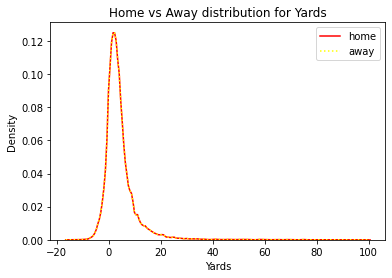

In [6]:
fig,ax=plt.subplots(nrows=1,ncols=1)
sns.kdeplot(data.Yards[data.Team=='home'],ax=ax,color='red',linestyle='solid')
sns.kdeplot(data.Yards[data.Team=='away'],ax=ax,color='yellow',linestyle=':')
plt.legend(['home','away'])
plt.title('Home vs Away distribution for Yards')
plt.plot()

***
No difference in Yards whether at home or away.
***

#### 2.21 Yardline

Yardline is measured with respect to the portion of the field where the play is happening. It never exceeds 50 but it can get confusing depending on the which team is attacking. 

For example yardline=20 could mean the team has 80 yards for a touchdown or 20 yards for a touchdown depending on the side of the field and direction of play. 
Converted that into a single number ranging from 0 to 100 and renamed all attacking teams as 'home' and all defending team as 'away' regardless of actual home or away

[]

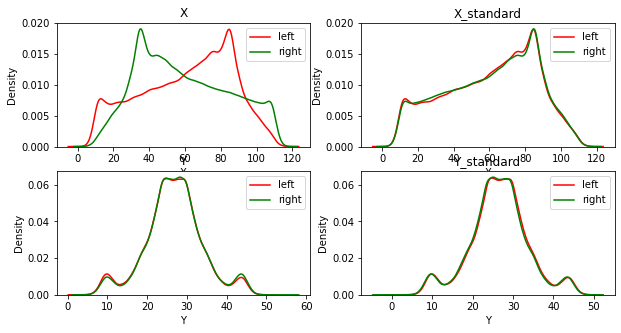

In [7]:
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(10,5))

sns.kdeplot(data.X[data.PlayDirection=='left'],ax=ax[0,0],color='red').set_title('X')
sns.kdeplot(data.X[data.PlayDirection=='right'],ax=ax[0,0],color='green')
ax[0,0].legend(['left','right'])

sns.kdeplot(data.X[data.PlayDirection=='left'],ax=ax[0,1],color='red')
sns.kdeplot(120-data.X[data.PlayDirection=='right'],ax=ax[0,1],color='green').set_title('X_standard')
ax[0,1].legend(['left','right'])

sns.kdeplot(data.Y[data.PlayDirection=='left'],ax=ax[1,0],color='red')
sns.kdeplot(data.Y[data.PlayDirection=='right'],ax=ax[1,0],color='green').set_title('Y')
ax[1,0].legend(['left','right'])

sns.kdeplot(data.Y[data.PlayDirection=='left'],ax=ax[1,1],color='red')
sns.kdeplot(160/3-data.Y[data.PlayDirection=='right'],ax=ax[1,1],color='green').set_title('Y_standard')
ax[1,1].legend(['left','right'])

plt.plot()

Changing Directions did not change the overall distribution of those variables

#### 2.22 Changes made
- Changing Direction of the plays to the Left if it is right. And switching the Coordinates, orientaion and other features dependent on the Direction of Play.
- Changing the possession team as always Home team and the defense team as away
- Creating a new feature **Rusher** to indicate if the player is the rusher or not
- Standardising the yardline
- Converting Direction from degress to radians for plotting

In [8]:
def standard_play():
    '''Function to standardise directions and other related variables'''
    
    data['Left']=data.PlayDirection=='left'
    
    data['X_std']=data.X
    data.loc[data.Left,'X_std']=120-data.loc[data.Left,'X']
    data['Y_std']=data.Y
    data.loc[data.Left,'Y_std']=160/3-data.loc[data.Left,'Y']
    
    #Rusher varibale to indicate the rushing player
    data['Rusher']=data.NflId==data.NflIdRusher
    
    data['Offense'] = "home"
    # If attacking team is not home team, it is treated as away team
    data.loc[data.PossessionTeam != data.HomeTeamAbbr, 'Offense'] = "away"
    # If Field position and possession team are same then the Yardline values stay same. Otherwise it is in the opposite direction
    data['YardLine_std'] = 100 - data.YardLine
    data.loc[data.FieldPosition == data.PossessionTeam,'YardLine_std'] = data.loc[data.FieldPosition == data.PossessionTeam,'YardLine']
    
    # Degrees to Radians subtracting by 90 since 0 degrees is upwards in raw data and it doesn't make intuitve sense, 
    # towards right is gven as 0 and towards left as 180 degrees or pi radians
    data['Dir_std']=np.mod(90-data.Dir,360)*np.pi/180
    #Flipping direction of all Left direction by pi radians (180 degrees)
    data.loc[data['Left'],'Dir_std']=np.mod(np.pi-data.loc[data['Left'],'Dir_std'],2*np.pi)
    
    return

standard_play()

## 3. EDA

#### Basic Stats

In [9]:
print("No of Unique Games:",len(data.GameId.unique()))
print("No of Unique Plays:",len(data.PlayId.unique()))

print("Number of Teams:",len(data.HomeTeamAbbr.unique()))
print("Number of Players:",len(data.NflId.unique()))
print("Number of Stadiums:",len(data.Stadium.unique()))

print("Minimum number plays from a Game:",int(data.GameId.value_counts().min()/22))
print("Median number plays from a Game:",int(data.GameId.value_counts().median()/22))
print("Maximum number plays from a Game:",int(data.GameId.value_counts().max()/22))
print('*'*40)
print("Season numbers")
print(data.Season.value_counts()/22)


No of Unique Games: 688
No of Unique Plays: 31007
Number of Teams: 32
Number of Players: 2570
Number of Stadiums: 61
Minimum number plays from a Game: 25
Median number plays from a Game: 45
Maximum number plays from a Game: 85
****************************************
Season numbers
2017    11900.0
2018    11271.0
2019     7836.0
Name: Season, dtype: float64


#### 3.1 Yards (The value to predict)

##### 3.11 Percentile values

In [10]:
x=PrettyTable()
x.field_names=["0-100 ","Percentiles","90-100 ","Percentiles ","99-100 "," Percentiles"]
for i in range(0,11,1):
    x.add_row(['{0} th percentile'.format(i*10),np.percentile(data.Yards,i*10),
               '{0} th percentile'.format(90+i),np.percentile(data.Yards,90+i),
               '{0} th percentile'.format(99+i/10),np.percentile(data.Yards,99+i/10)])
print(x)

+-------------------+-------------+-------------------+--------------+---------------------+--------------+
|       0-100       | Percentiles |      90-100       | Percentiles  |       99-100        |  Percentiles |
+-------------------+-------------+-------------------+--------------+---------------------+--------------+
|  0 th percentile  |    -15.0    |  90 th percentile |     10.0     |  99.0 th percentile |     28.0     |
|  10 th percentile |     -1.0    |  91 th percentile |     11.0     |  99.1 th percentile |     30.0     |
|  20 th percentile |     0.0     |  92 th percentile |     11.0     |  99.2 th percentile |     32.0     |
|  30 th percentile |     1.0     |  93 th percentile |     12.0     |  99.3 th percentile |     33.0     |
|  40 th percentile |     2.0     |  94 th percentile |     13.0     |  99.4 th percentile |     35.0     |
|  50 th percentile |     3.0     |  95 th percentile |     14.0     |  99.5 th percentile |     40.0     |
|  60 th percentile |     4.

***
99.9 percentile data points lie in the range -15 to 69 i.e 15 yards lost to 69 yards gained
***

In [11]:
print('IQR:',np.percentile(data.Yards,75)-np.percentile(data.Yards,25))

IQR: 5.0


##### 3.12 Distribution of Yards

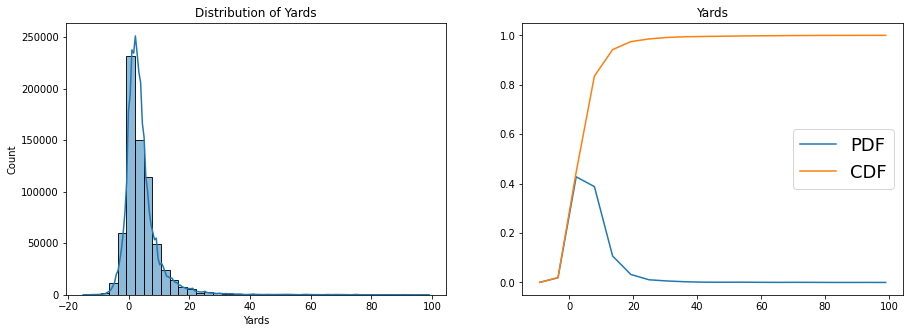

In [12]:
plt.figure(figsize=(15,5))

plt.subplot(121)
sns.histplot(data.Yards,bins=40,kde=True).set_title('Distribution of Yards')



plt.subplot(122)
counts, bin_edges = np.histogram(data.Yards, bins=20,
density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf);
plt.plot(bin_edges[1:], cdf)
plt.legend(['PDF','CDF'],fontsize=18,loc=7)
plt.title("Yards")
plt.show()

Yards is centered around 3 and 50% of the values lie in range 0 to 5.

It is slightly right skewed with a long tail 

#### 3.2 Distribution of Yards on each of the Downs

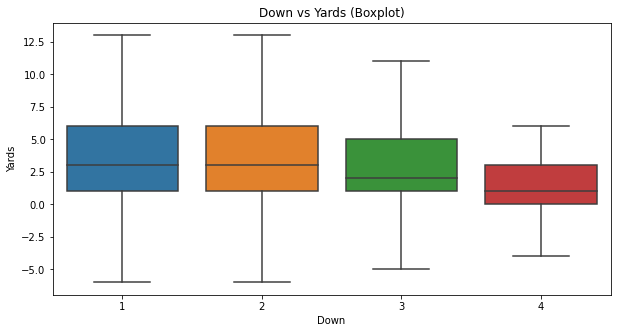

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data,y='Yards',x='Down',showfliers=False).set_title('Down vs Yards (Boxplot)')
plt.show()

As the Downs increase the Median Yards start decreasing

#### 3.3 Mean and Median of Yards based on the Down

In [14]:
print('Mean Yards on', data.groupby('Down').mean()['Yards'])
print("="*27)
print('Median Yards on', data.groupby('Down').median()['Yards'])

Mean Yards on Down
1    4.307950
2    4.201386
3    3.981413
4    2.097015
Name: Yards, dtype: float64
Median Yards on Down
1    3.0
2    3.0
3    2.0
4    1.0
Name: Yards, dtype: float64


### 3.4 Distance to Gain

10 yards is the most recorded distance since it is the distance at the start of every play, Bumps at 0,5,15,20 etc are for penalties for different infractions made by teams

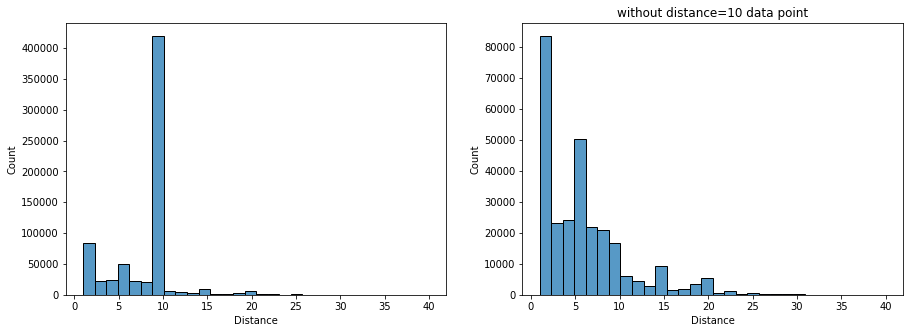

In [15]:
fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.histplot(data.Distance,bins=30,ax=ax[0])
sns.histplot(data.Distance[data.Distance!=10],bins=30,ax=ax[1]).set_title("without distance=10 data point")
plt.show()

### 3.5 Rusher Distance,Speed and Acceleration vs Yards

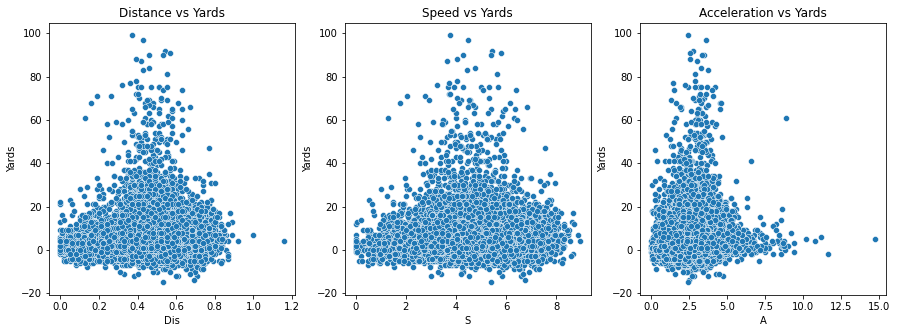

In [16]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(15,5))
sns.scatterplot(x=data.loc[data.Rusher,'Dis'],y=data.loc[data.Rusher,'Yards'],ax=ax[0]).set_title('Distance vs Yards')
sns.scatterplot(x=data.loc[data.Rusher,'S'],y=data.loc[data.Rusher,'Yards'],ax=ax[1]).set_title('Speed vs Yards')
sns.scatterplot(x=data.loc[data.Rusher,'A'],y=data.loc[data.Rusher,'Yards'],ax=ax[2]).set_title('Acceleration vs Yards')
plt.show()

For the Rusher, Acceleration has the best correlation , while speed and Distance show a looser relation, it is very noisy. A combination of these features could be useful using some physics equations of motion, further examination needed

### 3.6 Rusher Position vs Yards

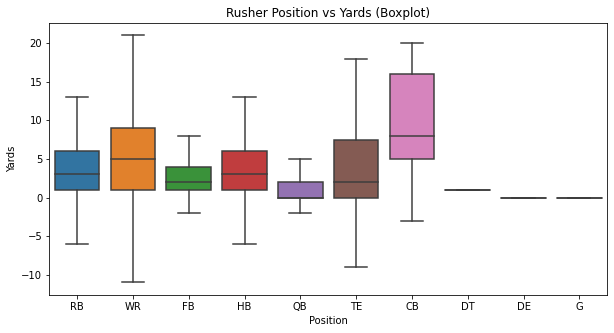

In [17]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data.loc[data.Rusher],y='Yards',x='Position',showfliers=False).set_title('Rusher Position vs Yards (Boxplot)')
plt.show()

CB Position seems to yield highest median Yards compared to the others. 

### 3.7 Offense Formation vs Yards

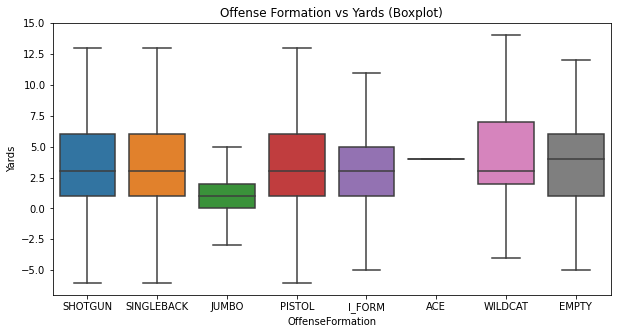

In [18]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data,y='Yards',x='OffenseFormation',showfliers=False).set_title('Offense Formation vs Yards (Boxplot)')
plt.show()

There does not seems to be a clear and obvious relationship between formation and Yards

### 3.8 Defenders in the Box vs Yards

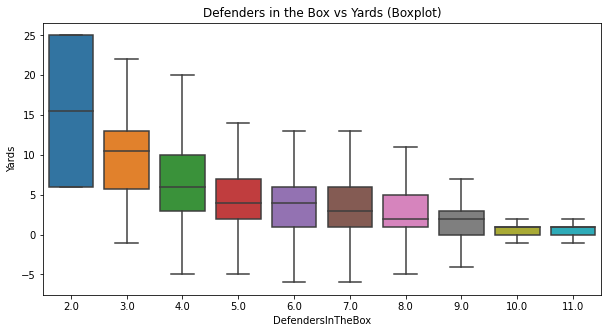

In [19]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data,y='Yards',x='DefendersInTheBox',showfliers=False).set_title('Defenders in the Box vs Yards (Boxplot)')
plt.show()

It seems to follow the logic of more Defenders in the box , harder to gain median Yards. 

2 Defenders in box with the biggest range of yards gained

### 3.9 Quarter vs Yards

5th Quarter indicating extra time

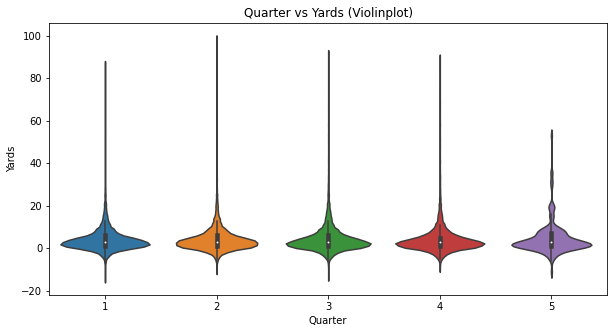

In [20]:
plt.figure(figsize=(10,5))
sns.violinplot(data=data,y='Yards',x='Quarter',showfliers=False).set_title('Quarter vs Yards (Violinplot)')
plt.show()

### 3.10 Yardline vs Yards Contour Plot

Creating a dataframe of features per play, to remove redundant rows.

In [21]:
play=['GameId', 'PlayId','YardLine_std','Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance','Yards','DefendersInTheBox']
l=[]
for i,j in tqdm(data.iterrows()):
    if i%21==0:
        l.append(j[play])

temp=pd.DataFrame()        
play_df=temp.append(pd.DataFrame(l))
play_df

0it [00:00, ?it/s]

,GameId,PlayId,YardLine_std,Quarter,GameClock,PossessionTeam,Down,Distance,Yards,DefendersInTheBox
0,2017090700,20170907000118,35,1,14:14:00,NE,3,2,8,6.0
21,2017090700,20170907000118,35,1,14:14:00,NE,3,2,8,6.0
42,2017090700,20170907000139,43,1,13:52:00,NE,1,10,3,6.0
63,2017090700,20170907000189,65,1,13:02:00,NE,1,10,5,7.0
84,2017090700,20170907000345,98,1,12:12:00,NE,2,2,2,9.0
...,...,...,...,...,...,...,...,...,...,...
682059,2019112500,20191125003419,46,4,09:47:00,BLT,1,10,1,8.0
682080,2019112500,20191125003440,47,4,09:03:00,BLT,2,9,1,7.0
682101,2019112500,20191125003496,87,4,08:04:00,BLT,1,10,1,8.0
682122,2019112500,20191125003768,37,4,04:55:00,BLT,1,10,1,7.0


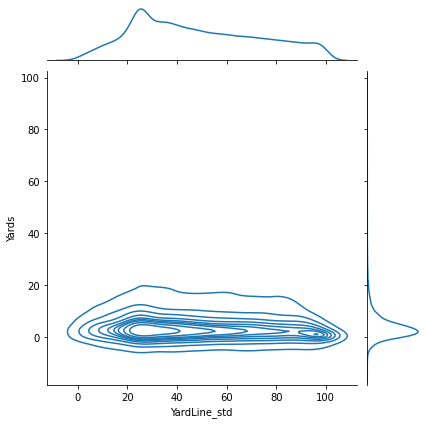

Wall time: 35.9 s


In [22]:
%%time
sns.jointplot(x='YardLine_std',y='Yards',data=play_df,kind='kde')
plt.show()

Yardline_std is evenly distributed across the full range but yards majorly concentrated in region -2 to 10

### 3.11 Distance to first down vs Yards Contour Plot with Downs

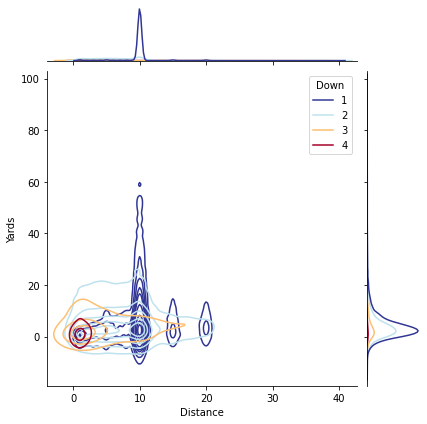

Wall time: 40.5 s


In [23]:
%%time
sns.jointplot(x='Distance',y='Yards',data=play_df,kind='kde',hue='Down',palette='RdYlBu_r')
plt.show()

For Distance less than or equal to 10 , more Yards were gained. 4th Down had the lowest distance and Yards. 2nd Down had the most variability in the range of Distanceand Yards gained.
1st Down naturally has 10 yards as per the rules but a lot of variability in Yards gained. Compared to second,third and fourth down.

## 4. Feature Engineering

### 4.1 Distance Feature

Distance feature isn't distributed in similar manner around 0.0 and 0.01 range for 2017 season vs the other seasons.<br>
Randomly added noise to the 2 data points to match with the distributions of the other 2 seasons improved correlation by 14%

In [24]:
data.Dis[(data.Season==2017) & (data.Dis<0.1)].value_counts()

0.01    4458
0.09    3971
0.08    3599
0.07    3420
0.06    2959
0.05    2697
0.00    2392
0.04    2335
0.03    2033
0.02    1886
Name: Dis, dtype: int64

In [25]:
data.Dis[(data.Season==2018) & (data.Dis<0.1)].value_counts()

0.09    4469
0.08    4209
0.07    3745
0.06    3547
0.05    3078
0.04    2556
0.03    2077
0.02    1431
0.01     798
0.00     188
Name: Dis, dtype: int64

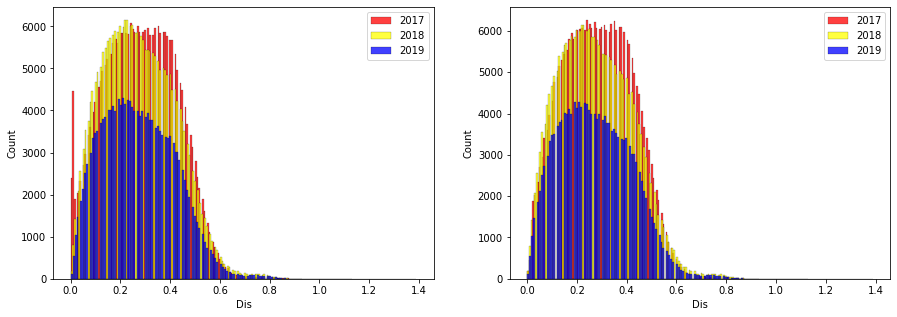

Wall time: 2.5 s


In [26]:
%%time
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
x='Dis'
sns.histplot(data.loc[data.Season==2017,x],label=2017,color='red',ax=ax[0])
sns.histplot(data.loc[data.Season==2018,x],label=2018,color='yellow',ax=ax[0])
sns.histplot(data.loc[data.Season==2019,x],label=2019,color='blue',ax=ax[0])
ax[0].legend()

old_correlation=data.Yards.corr(data.Dis)

#Values taken just from looking at the distrubition of data after comparing 2017 with other Seasons(2018/19)
#Number of samples also taken after looking at the corresponding values in 2018/2019 data respectively 
index=data.loc[(data.Season==2017) & (data.Dis==0.0)].sample(2200).index                                          
data.loc[index.values,'Dis']=np.round(np.random.uniform(0.1,0.4,2200),decimals=2)      
index=data.loc[(data.Season==2017) & (data.Dis==0.01)].sample(4000).index
data.loc[index.values,'Dis']=np.round(np.random.uniform(0.1,0.4,4000),decimals=2)

sns.histplot(data.loc[data.Season==2017,x],label=2017,color='red',ax=ax[1])
sns.histplot(data.loc[data.Season==2018,x],label=2018,color='yellow',ax=ax[1])
sns.histplot(data.loc[data.Season==2019,x],label=2019,color='blue',ax=ax[1])
ax[1].legend()
plt.show()

new_correlation=data.Yards.corr(data.Dis)

In [27]:
print(np.round(((new_correlation-old_correlation)/old_correlation)*100,decimals=3),"% improvement in correlation" )

14.193 % improvement in correlation


### 4.2 Speed Vs Distance

coeff for 2017 : 8.029203479235585
coeff for 2018 : 9.922795065204655
coeff for 2019 : 10.067518983481769
Linear Correlation between Speed and distance before: 0.003393453794717061
Correlation between Speed and distance after: 0.0018145196964580866


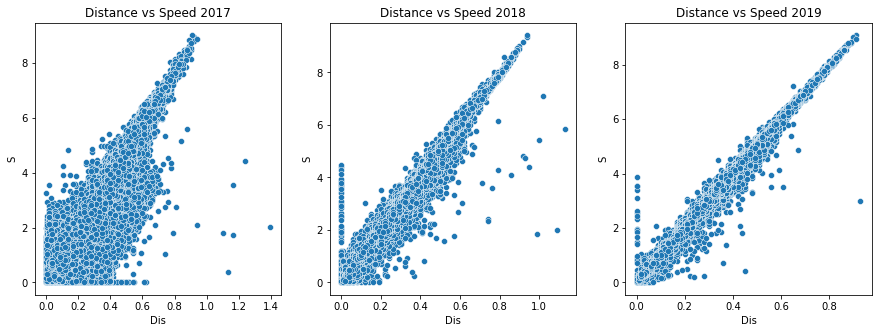

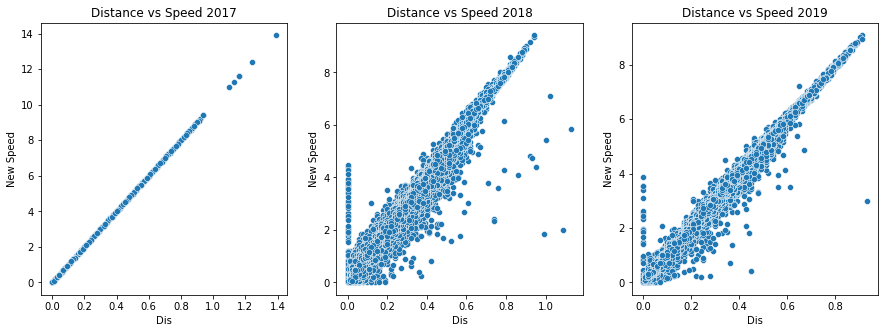

In [28]:
from sklearn.linear_model import LinearRegression

fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,5))
for i in range(0,3):
    sns.scatterplot(x=data.Dis[data.Season==2017+i],y=data.S[data.Season==2017+i],ax=ax[i]).set_title('Distance vs Speed {0}'.format(2017+i))

for i in [2017,2018,2019]:
    l=LinearRegression()
    l.fit(np.array(data.Dis[data.Season==i]).reshape(-1,1),np.array(data.S[data.Season==i]).reshape(-1,1))
    print('coeff for',i,":",l.coef_[0][0])
print("Linear Correlation between Speed and distance before:",data.Yards.corr(data.S))

data.loc[(data.Season==2017) ,'New Speed']=data.loc[(data.Season==2017),'Dis']*10
data.loc[(data.Season>2017) ,'New Speed']=data.loc[(data.Season>2017),'S']

fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,5))

for i in range(0,3):
    sns.scatterplot(x=data.Dis[data.Season==2017+i],y=data['New Speed'][data.Season==2017+i],ax=ax[i]).set_title('Distance vs Speed {0}'.format(2017+i))

print("Correlation between Speed and distance after:",data.Yards.corr(data['New Speed']))

Correlation became worse, So keeping the original values 

In [29]:
data.drop('New Speed',axis=1,inplace=True)

### 4.3 Orientation 

2017 Orientation looks shifted by exactly 90 degrees, adjusting for the phase difference also improves the correlation with Yards

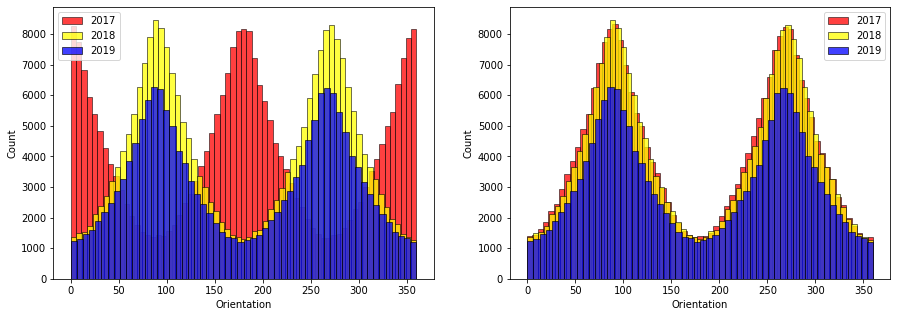

Wall time: 1.5 s


In [30]:
%%time
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.histplot(data.loc[data.Season==2017,'Orientation'],label=2017,color='red',ax=ax[0])
sns.histplot(data.loc[data.Season==2018,'Orientation'],label=2018,color='yellow',ax=ax[0])
sns.histplot(data.loc[data.Season==2019,'Orientation'],label=2019,color='blue',ax=ax[0])
ax[0].legend()

old=data.Yards.corr(data.Orientation)
data.loc[data.Season==2017,'Orientation']=np.mod(89.5+data.loc[data.Season==2017,'Orientation'],360)

sns.histplot(data.loc[data.Season==2017,'Orientation'],label=2017,color='red',ax=ax[1])
sns.histplot(data.loc[data.Season==2018,'Orientation'],label=2018,color='yellow',ax=ax[1])
sns.histplot(data.loc[data.Season==2019,'Orientation'],label=2019,color='blue',ax=ax[1])
ax[1].legend()
plt.show()

new=data.Yards.corr(data.Orientation)

In [31]:
print(np.round(((new-old)/old)*100,decimals=3),"% improvement in correlation" )

456.699 % improvement in correlation


### Relative Distances

In [32]:
X=data[(data.PlayId==20170907000118)][['X_std','Y_std']].values

In [33]:
dist=np.zeros(shape=(22,22))
for i in range(22):
    for j in range(i+1,22):
        d=((X[i][0]-X[j][0])**2+(X[i][1]-X[j][1])**2)**(0.5)
        dist[i,j]=d
        dist[j,i]=d

In [34]:
dist[:,0]

array([ 0.        ,  2.32757384,  1.64246766,  7.54864889,  4.62649976,
       10.90083024, 18.20109887, 16.11904774, 19.01688723,  4.0291066 ,
        5.94484651, 17.38523799,  1.84764715,  2.86623446,  9.92161781,
        7.92748384,  3.29218772, 15.66992661,  6.48087185,  3.03935848,
        5.75910583,  6.40513856])

## 5. Modelling